In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace

In [5]:
# Define paths to your training and testing directories
train_dir = 'Datasets/RAF-DB/DATASET/train'
test_dir = 'Datasets/RAF-DB/DATASET/test'

# Adjust the image size for VGG-Face
image_size = (224, 224)  # VGG-Face expects 224x224 input
batch_size = 64

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for the test set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories and resize them
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


train_generator and test_generator are now ready to be used in model training and evaluation

In [6]:
# Load the VGG-Face model without the top layer
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [8]:
epochs = 15  # Increased number of epochs

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/15
 13/448 [..............................] - ETA: 13:26 - loss: 2.9011 - accuracy: 0.1478

KeyboardInterrupt: 

225/225 [==============================] - 6s 24ms/step - loss: 1.2697 - accuracy: 0.5114
Test accuracy:  0.5114237666130066
225/225 [==============================] - 4s 16ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.11      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.06      0.08      1024
       happy       0.25      0.33      0.28      1774
     neutral       0.17      0.21      0.19      1233
         sad       0.16      0.17      0.17      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.17      7178


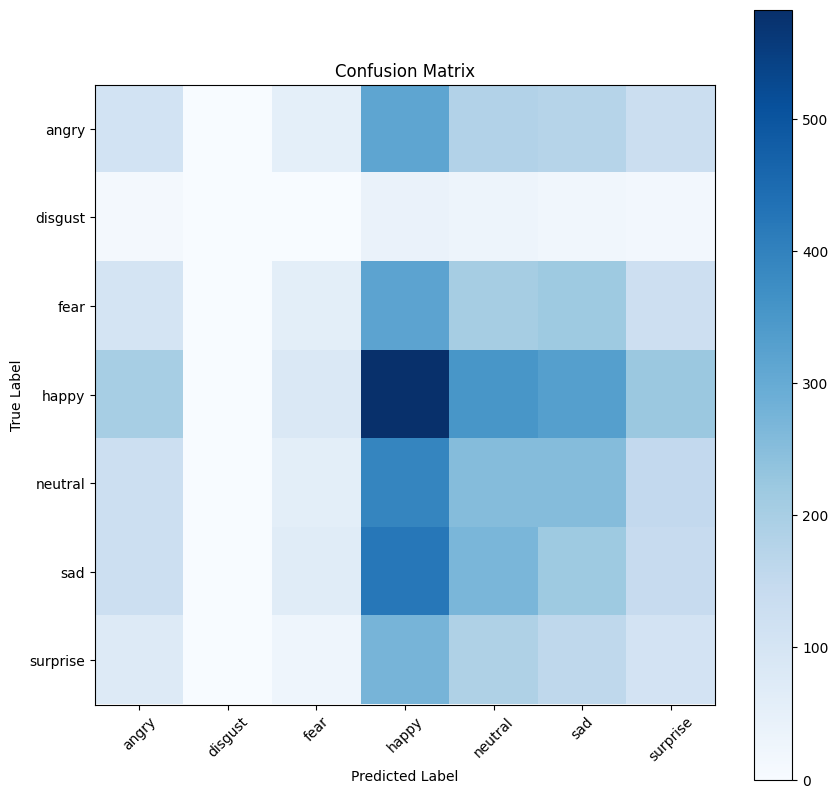

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making